In [4]:
import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [5]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/sines_4/2_4_8/1714557588'

data_path = root_path + test_path + '/y.pt'

Y = torch.load(data_path).to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])

sid = [0,32,64,96]
Y = Y[sid, :]

print(f'x: {x.shape}, Y: {Y.shape}')

x: (200,), Y: (4, 200)


Text(0.5, 1.0, 'Demonstrations')

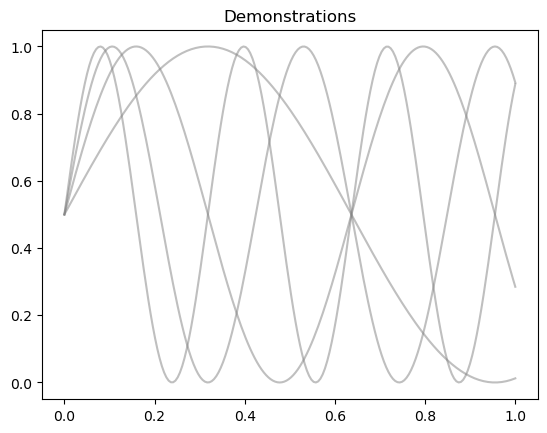

In [6]:
for i in range(Y.shape[0]):
    plt.plot(x, Y[i, :], 'gray', alpha=0.5)

plt.title('Demonstrations')

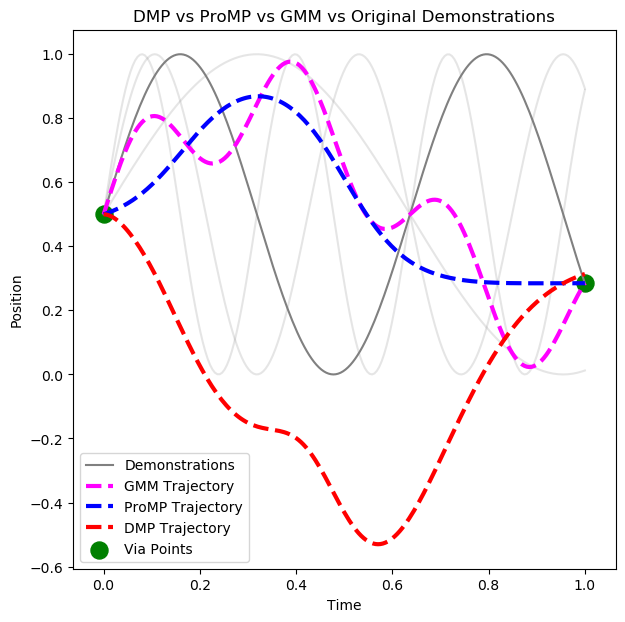

In [7]:
d = DMP(n_dims=1, n_weights_per_dim=4, dt=1/Y.shape[1])

ind = 1
sp, ep = Y[ind, 0], Y[ind, -1]  # Start and end points

plt.rcParams['figure.figsize'] = [7, 7]

for i, traj in enumerate(Y):
    d.imitate(x, traj.reshape(-1,1))
    if i == ind:
        plt.plot(x, traj, color='gray', label='Demonstrations')
    else:
        plt.plot(x, traj, color='gray', alpha=0.2)  # Original trajectories in gray

d.configure(start_y=[sp], goal_y=[ep])
t, trajectory = d.open_loop()

p = ProMP(n_dims=1, n_weights_per_dim=4)
p.imitate(np.tile(x, (Y.shape[0], 1)), Y)
p = p.condition_position(sp, t=0).condition_position(ep, t=1)
trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

input_data = x.reshape(-1, 1)  # Phase variable as a column vector

priors = 4  # Number of GMM components
gmr_model = GMM(n_components=priors, random_state=1234)
gmr_model.from_samples(Y)
gmr_model = gmr_model.condition([0, -1], [sp, ep])
trajectory_g = gmr_model.sample(1)
trajectory_g = np.insert(trajectory_g, 0, sp)
trajectory_g = np.append(trajectory_g, ep)


# Plot generated trajectories
plt.plot(x, trajectory_g, label='GMM Trajectory', color='magenta', linewidth=3, linestyle='dashed')
plt.plot(x, trajectory_p[0,:,0], label='ProMP Trajectory', color='blue', linewidth=3, linestyle='dashed')
plt.plot(t, trajectory, label='DMP Trajectory', color='red', linewidth=3, linestyle='dashed')
plt.scatter([0, 1], [sp, ep], color='green', label='Via Points', s=150)  # Via points
plt.legend(loc='lower left')
plt.title('DMP vs ProMP vs GMM vs Original Demonstrations')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()